Image Processing and Computer Vision 2021/22

### CAPS INSPECTION
### Project 2_Cavity number preprocessing

Junjie Zhu - junjie.zhu3@studio.unibo.it - 0001030002

Jiacheng Zhang - jiacheng.zhang@studio.unibo.it - 0001038421

Wenxi Huo - wenxi.huo@studio.unibo.it - 0001035935

In [1]:
# improt necessary libraries/modules for image processing and visualization
import numpy as np
import cv2
from matplotlib import pyplot as plt
import os
import math

#### 1. Pre-processing
Load task images from the local file folder, convert original images to both RGB and Grayscale formats using OpenCV, and store them in separate lists while displaying the total set number of original images waiting to be processed.

In [2]:
images_gray = [] # List to store grayscale images
images_rgb = [] # List to store RGB images

folder_path = 'cap-inspection-images/project_2_cavity_number/'

# Check if the folder exists
if os.path.exists(folder_path):
    
    file_names = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

    # Iterate through each file in the folder
    for file_name in file_names:
        file_path = os.path.join(folder_path, file_name)
        if file_path.endswith(('.bmp')):
            img = cv2.imread(file_path)
            images_rgb.append(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
            images_gray.append(cv2.cvtColor(img,cv2.COLOR_BGR2GRAY))
    print('Loaded '+ str(len(images_gray))+ ' images!')
else:
    print('Folder not found. Please provide a valid folder path.')

Loaded 29 images!


#### 2. First task: generate a crop of the cavity number
##### 2.1. Outline the cap by generating a circle that fits the cap mouth

In this task, the noise background at the corner of the image can be removed because it is far away from the detection object, and the detection object can also be easily distinguished from the black background in the surounding area, so there is no background interference. 

However, when detecting the outer contour circle of the cap, since there are multiple circular structures on the surface of the cap itself, the centers of which are approximately concentric and the radius difference is very small, the detection difficulty is greatly increased. 

Therefore, after **median blur** as pre-process, in order to reduce internal interference, the image is **binarized** and only the outermost contour is retained to apply **Hough Circle detection**. The tab on the outer contour is kept because it is smaller compare to the whole object and has less impact on the hough circle tansform detection.

After fine-tuning the parameters of Hough Transform function cv2.HoughCircles(), the found cap mouth outlines are shown in green as follow.

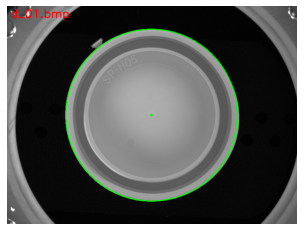

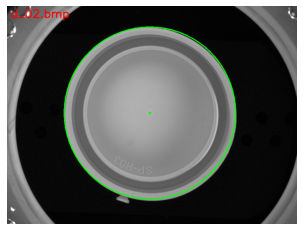

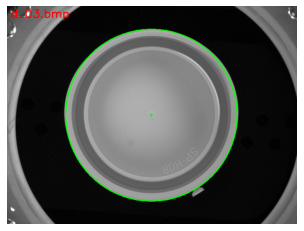

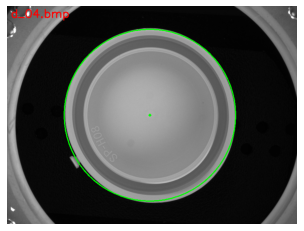

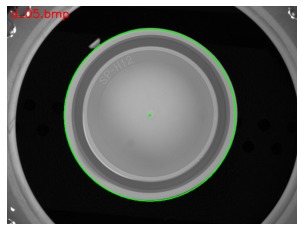

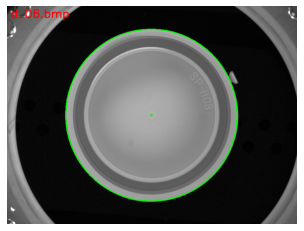

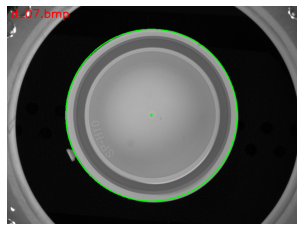

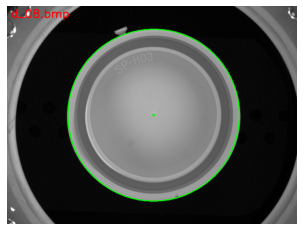

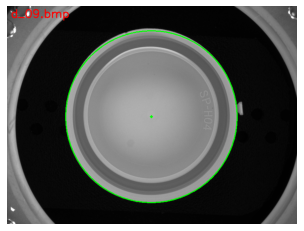

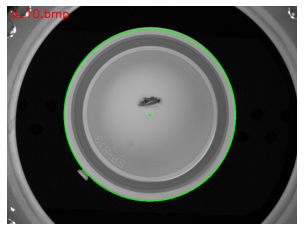

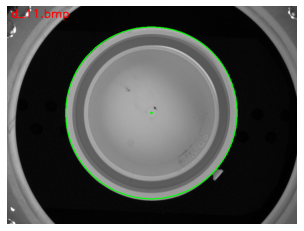

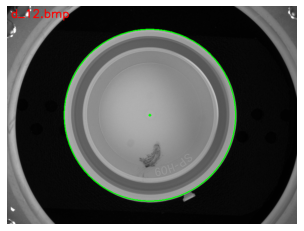

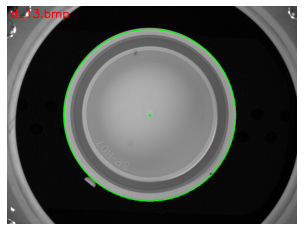

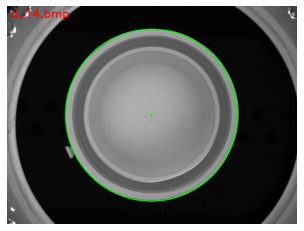

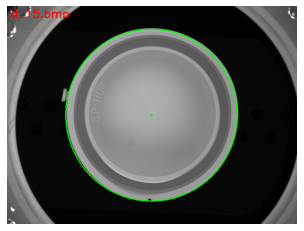

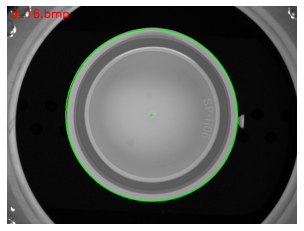

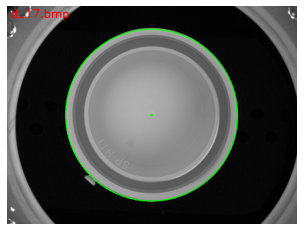

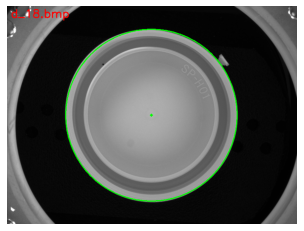

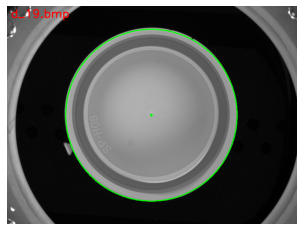

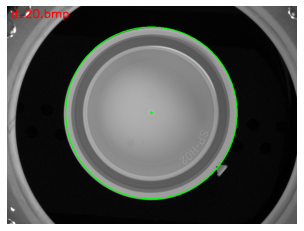

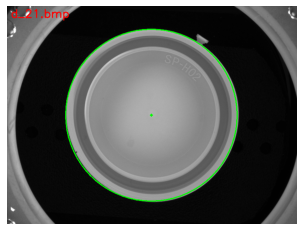

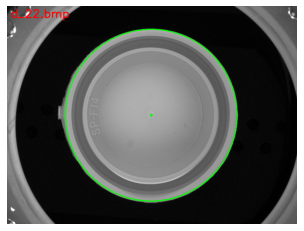

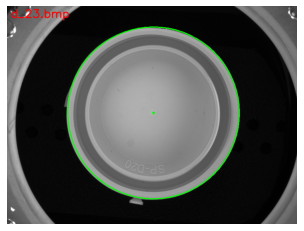

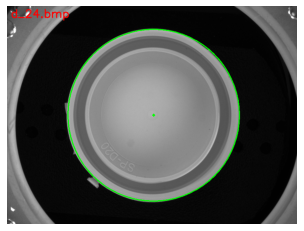

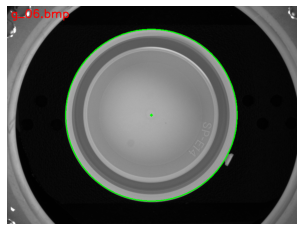

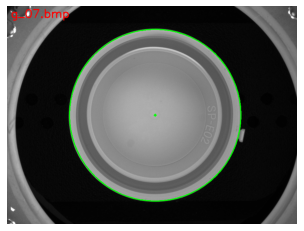

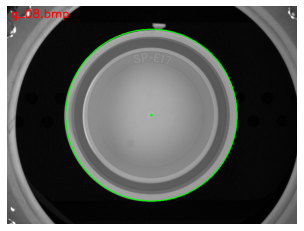

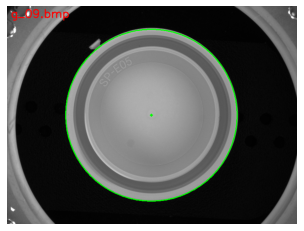

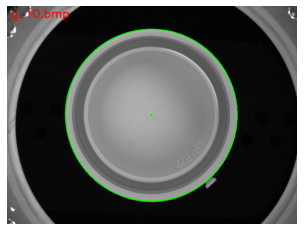

In [3]:
binary_image = [] # List to store binary images
cap_center = [] # List to store detected cap centers
cap_circle_img = [] # List to store images with detected cap circles

for index, img_gray in enumerate(images_gray):
    cap_circle_img.append(np.copy(images_rgb[index]))
    
    # Apply median blur to the grayscale image
    median_blur = cv2.medianBlur(img_gray, 3)  
    # plt.imshow(median_blur, cmap='gray')
    # plt.show()
    
    # Apply thresholding to create a binary image
    _, binary = cv2.threshold(median_blur, 30, 255, cv2.THRESH_BINARY)
    binary_image.append(binary)
#     plt.imshow(binary, cmap='gray')
#     plt.show()
    
    # Apply Hough Circle Transform to detect circles in the binary image
    cap_circle = cv2.HoughCircles(binary, cv2.HOUGH_GRADIENT, dp=5, minDist=200,
                               param1=150,param2=100,minRadius=225,maxRadius=230)

    if cap_circle is not None:
        cap_circle = np.uint16(np.around(cap_circle))
        for i in cap_circle[0, :]:
            center = (i[0], i[1])
            radius = i[2]
            cap_center.append((center,radius))
            cv2.circle(cap_circle_img[index], center, radius, (0, 255, 0), 2)
            cv2.circle(cap_circle_img[index], center, 2, (0, 255, 0), 3)
    else:
        print("No cap circle detected.")
        
    # Add file name text and display the image with detected circles
    cv2.putText(cap_circle_img[index], file_names[index], (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, 255, 2)
#     captext = f"Center:{cap_center[index][0][0],cap_center[index][0][1]}"
#     cv2.putText(cap_circle_img[index], captext, (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, 255, 2)
#     radiustext = f"R:{cap_center[index][1]}"
#     cv2.putText(cap_circle_img[index], radiustext, (10, 90), cv2.FONT_HERSHEY_SIMPLEX, 1, 255, 2)
           
    plt.imshow(cap_circle_img[index], cmap='gray')
    plt.axis('off')
    plt.show()

#### 2. First task: generate a crop of the cavity number
##### 2.2. Generate a crop containing the cavity number.

The task requires that the crop should contain the cavity number and it should be in an upright position which can be divided into two steps. First, rotate the whole cap image so that the number is at the targeted position, and then crop the image to get the cavity number.

In order to reduce the amount of calculation and facilitate image rotation, an ROI image of only the cap is first generated.

Based on the above cap mouth circle detection results, expand the radius of the circle(mask_range) and retain the tabs. 

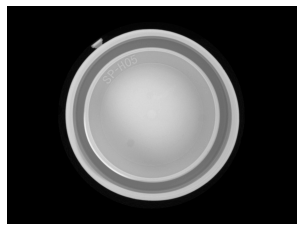

In [4]:
mask_range = 20 # Expansion value of circle radius
masked_cap = [] # List to store masked cap images
binary_cap = [] # List to store binary cap images

for index, img_gray in enumerate(images_gray):
    mask = np.zeros_like(img_gray)
    
    # Create a circular mask around the cap center
    cv2.circle(mask, (cap_center[index][0][0],cap_center[index][0][1]), 
               cap_center[index][1]+mask_range, 255, -1)
    
    # Apply mask to the grayscale image
    masked_cap.append(cv2.bitwise_and(img_gray,mask))
#     plt.imshow(masked_cap[index], cmap='gray')
#     plt.show()

plt.imshow(masked_cap[0], cmap='gray')
plt.axis('off')
plt.show()

After testing multiple methods, for the problem of locating the label, we settled on the following method, which relies on utilizing the previously identified cap mouth circle (**red point and circle**) as a reference point. This method aims to isolate contour points situated beyond a specified radial distance on the outer contour of the bottle cap. These identified points represent the outermost contour of the tab, forming the line segment on the tab (**blue point** in the images below).These points are then used to estimate the tab's center, represented by a visual **green point** on the images. 

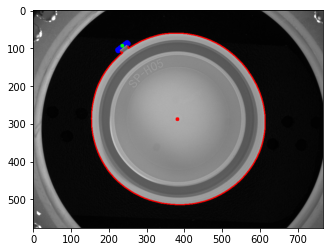

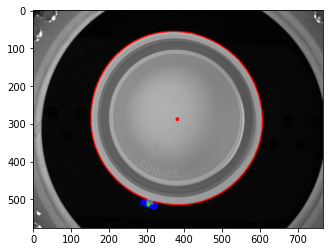

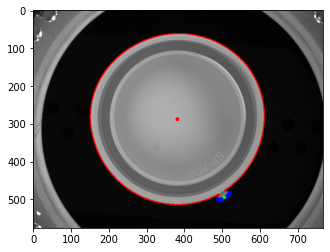

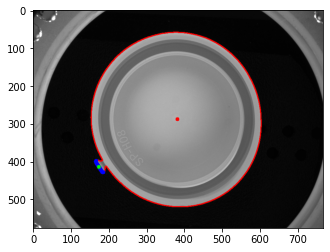

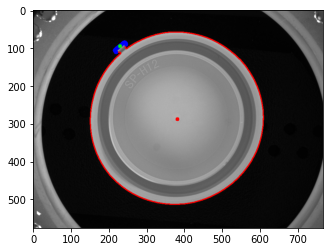

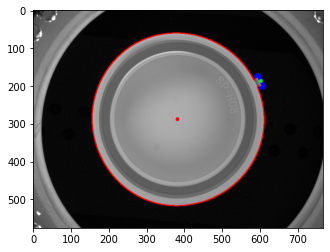

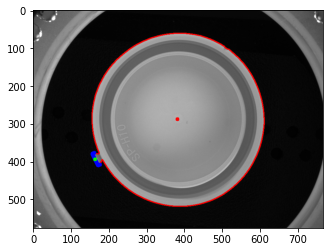

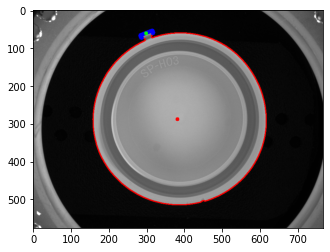

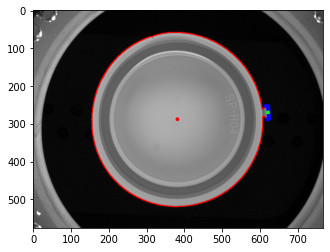

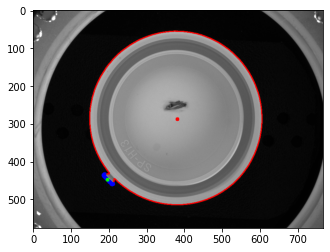

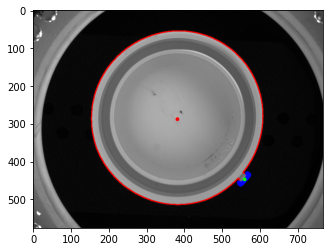

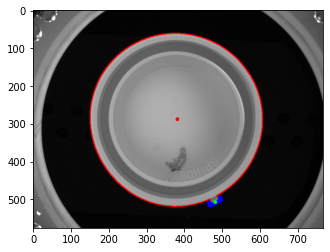

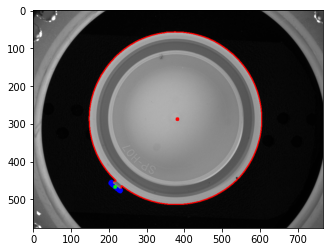

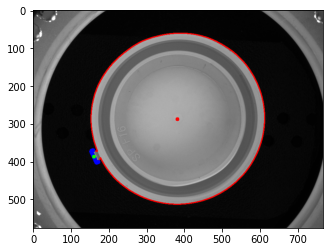

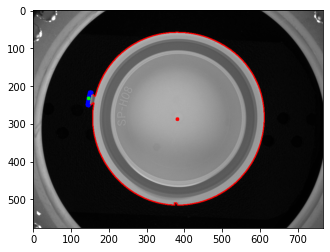

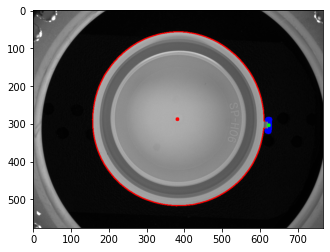

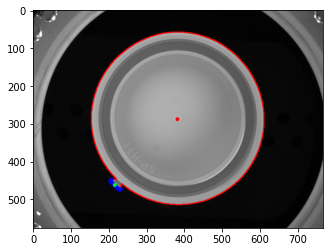

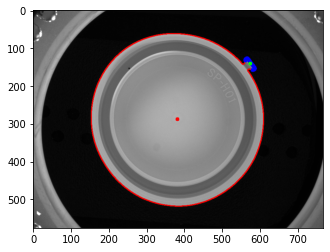

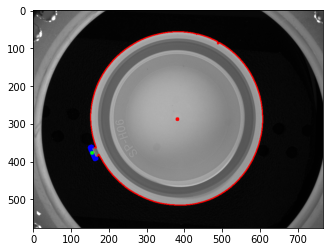

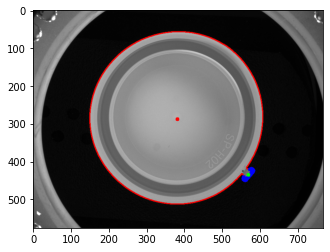

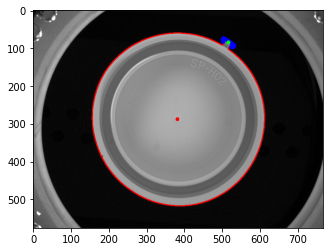

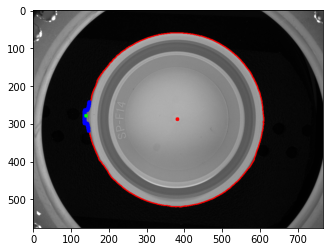

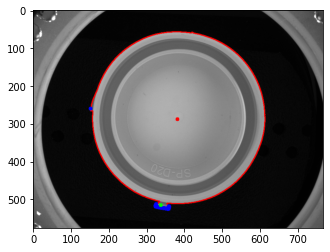

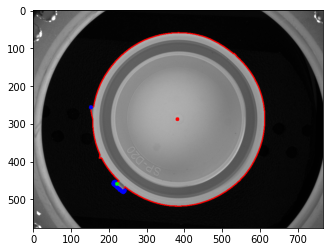

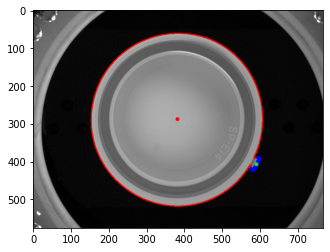

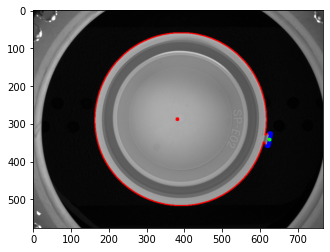

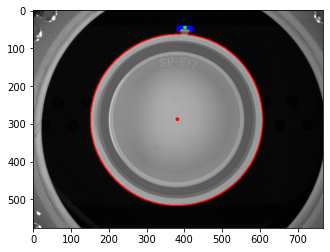

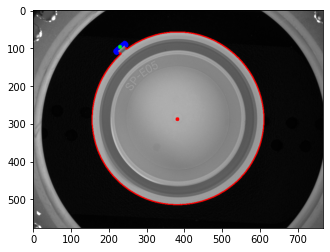

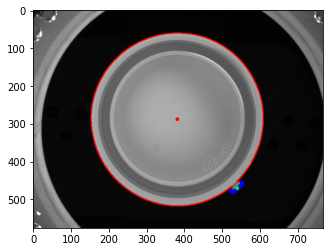

In [5]:
tab_line = [] # List to store images with detected tabs
tab_center = [] # List to store detected tab centers

for index, m_cap in enumerate(masked_cap):
    _, binary_image = cv2.threshold(m_cap, 50, 255, cv2.THRESH_BINARY)
    binary_cap.append(binary_image)
#     plt.imshow(binary_image, cmap='gray')
#     plt.show()

    max_distance_threshold = cap_center[index][1]+10 # Threshold for maximum distance from cap center
    
    tab_points = []
    tab_line.append(np.copy(images_rgb[index]))
    
    # Find contours in the binary image
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if contours is not None:
        for contour in contours:
            cv2.drawContours(tab_line[index], [contour], -1, (255, 0, 0), 2)

            for point in contour:
                    px, py = point[0]
                
                    # Calculate distance between the point and cap center
                    distance = np.sqrt((px - cap_center[index][0][0])**2 + 
                                       (py - cap_center[index][0][1])**2)
                    if distance > max_distance_threshold:
                        tab_points.append((px, py)) # Store points outside the threshold
                        cv2.circle(tab_line[index], (px, py), 5, (0, 0, 255), -1)
    
        if tab_points is not None:
            
            # Calculate the average coordinates of tab points to estimate tab center
            tab_center.append((
                sum([point[0] for point in tab_points]) // len(tab_points),
                sum([point[1] for point in tab_points]) // len(tab_points)
            ))

            # Draw a point at the estimated tab center
            cv2.circle(tab_line[index], tab_center[index], 5, (0, 255, 0), -1)
    #         print("Center of tab:", tab_center[index])
        else:
            print("No tab_points found!")
            
        # Draw a point at the cap center
        cv2.circle(tab_line[index], center, 5, (255, 0, 0), -1)            
        plt.imshow(tab_line[index])
        plt.show()
    else:
        print("No contours found!")

After getting the centers of the tab and the cap, calculates **the rotation angle** based on the slopes between the two centers, then uses this angle to get **the rotation matrix** then apply **affine transformation** to rotate the masked cap images accordingly. 

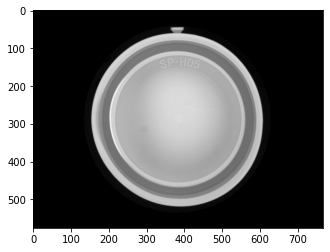

In [6]:
rotate_angle = [] # List to store calculated rotation angles
rotated_image = [] # List to store rotated images

for index, m_cap in enumerate(masked_cap):
    
    rows, cols= m_cap.shape
    
    # Extract coordinates for tab and cap centers
    y2=tab_center[index][1]
    y1=cap_center[index][0][1]
    x2=tab_center[index][0]
    x1=cap_center[index][0][0]

    # Calculate the slope between tab and cap centers
    slope = (y2 - y1) / (x2 - x1)
    angle = math.atan(slope) * 180 / math.pi # Calculate the angle

    # Determine the rotation angle based on the slope direction
    if x2 > x1:
        rotate_angle.append(angle+90)
    else:
        rotate_angle.append(angle-90)

#     print("rotate_angle:", rotate_angle[index])

    # Get the rotation matrix and perform the rotation
    M = cv2.getRotationMatrix2D((x1, y1), rotate_angle[index], 1)
    rotated_image.append(cv2.warpAffine(m_cap, M, (cols, rows)))

#     plt.imshow(rotated_image[index], cmap='gray')
#     plt.show()
plt.imshow(rotated_image[0], cmap='gray')
plt.show()

According to the obtained tab center, calculate the relative position of the cavity number and then crop the image.

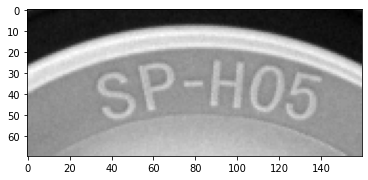

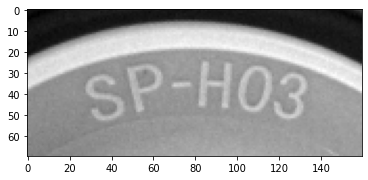

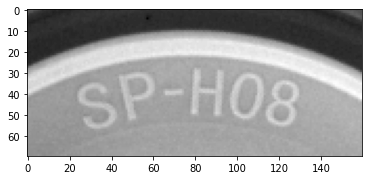

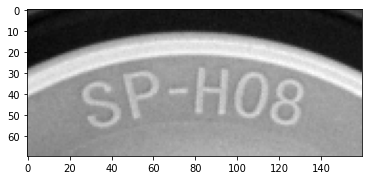

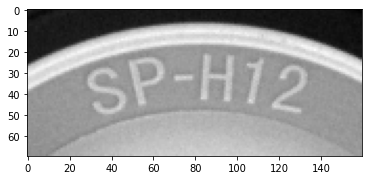

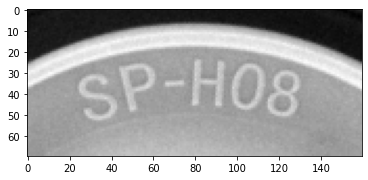

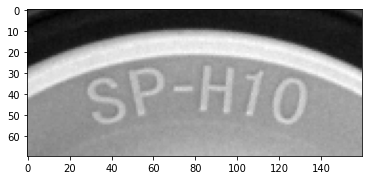

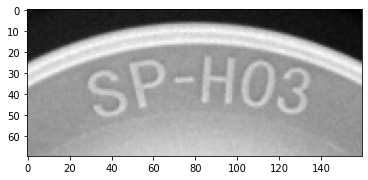

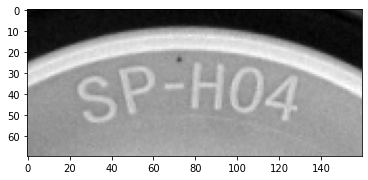

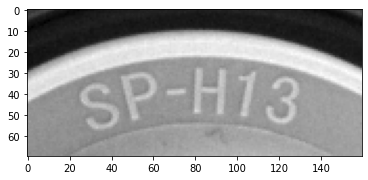

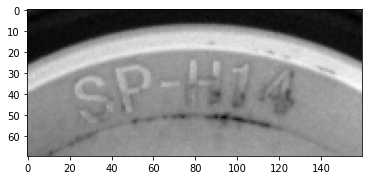

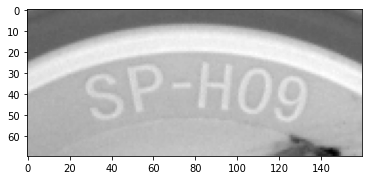

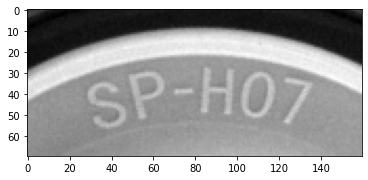

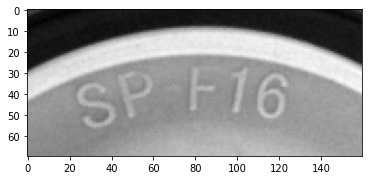

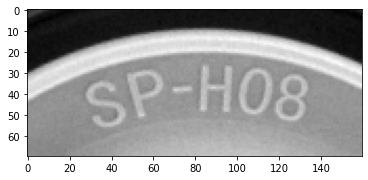

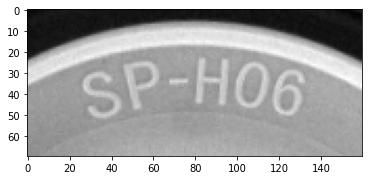

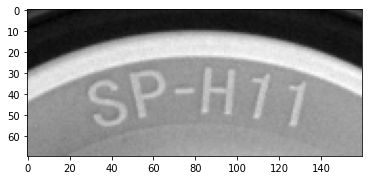

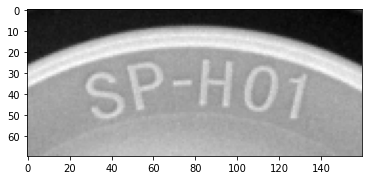

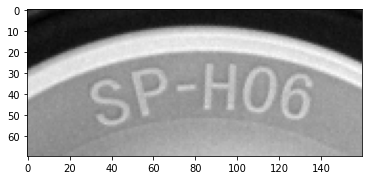

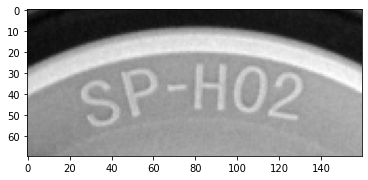

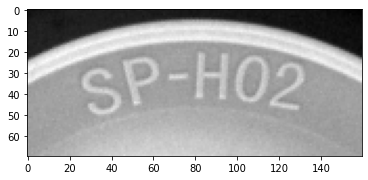

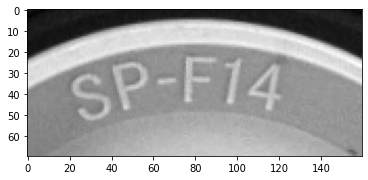

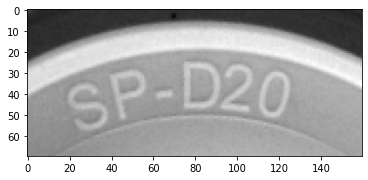

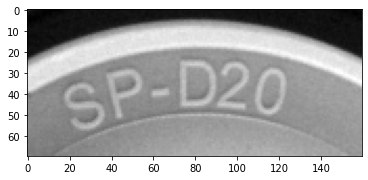

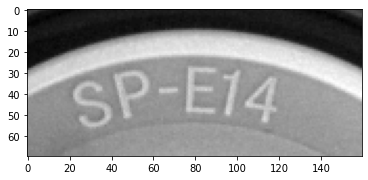

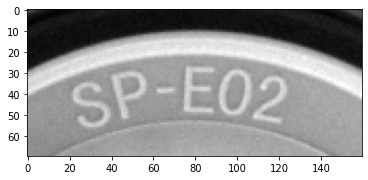

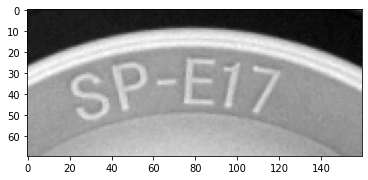

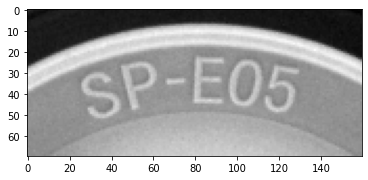

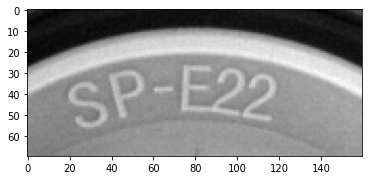

In [7]:
cropped_image = [] # List to store cropped images

for index, rot_img in enumerate(rotated_image):
    
    # Define coordinates for the top-left and bottom-right corners of the region to be cropped
    top_left = (cap_center[index][0][0]-80, cap_center[index][0][1]-cap_center[index][1]+40)
    bottom_right = (cap_center[index][0][0]+80, cap_center[index][0][1]-cap_center[index][1]+110) 
    
    # Crop the region of interest from the rotated image
    cropped_image.append(rot_img[top_left[1]:bottom_right[1], top_left[0]:bottom_right[0]])
    
    plt.imshow(cropped_image[index], cmap='gray')
    plt.show()

#### 3. Second task: generate a rectified crop of the cavity number

Performs a **polar transformation** on the rotated images to convert them into polar coordinates using cv2.warpPolar(). After that, extracts an ROI from the polar-transformed images with the cavity number. This ROI is a rectified crop of the cavity number required by the task.

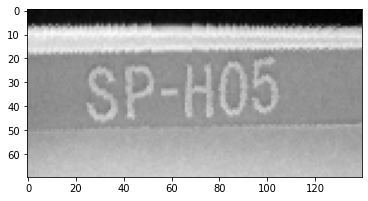

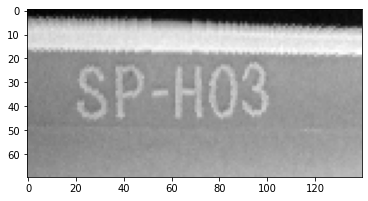

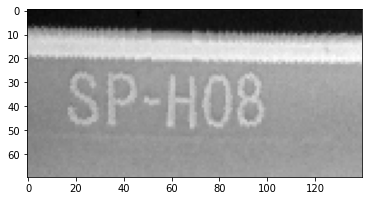

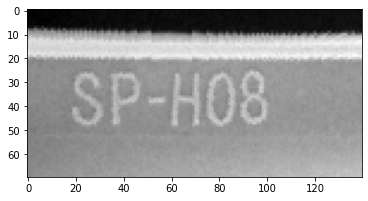

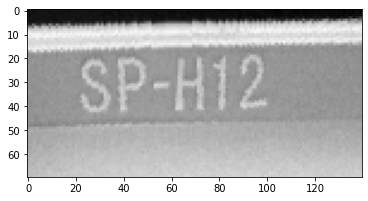

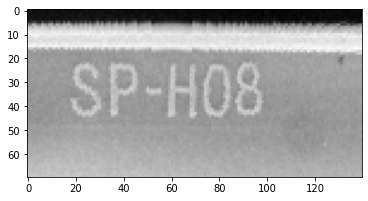

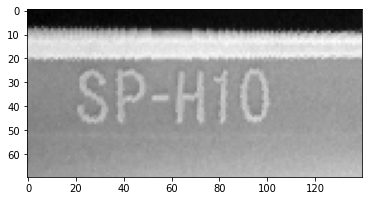

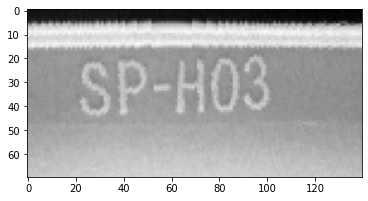

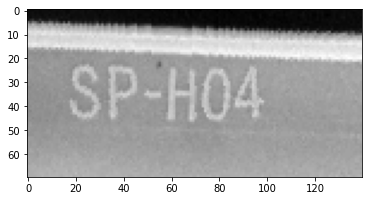

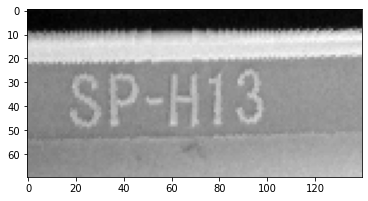

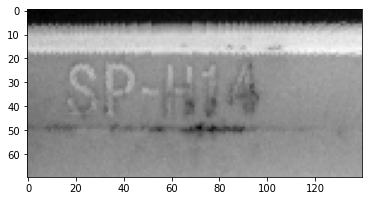

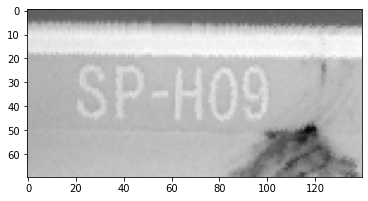

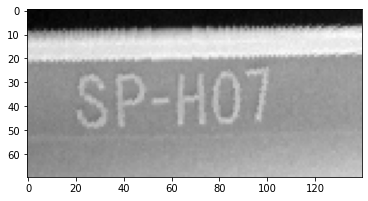

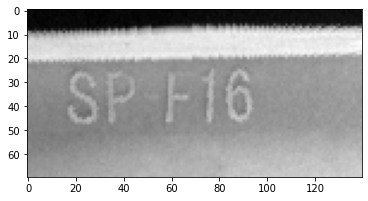

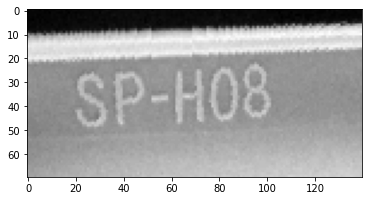

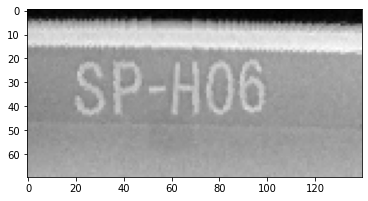

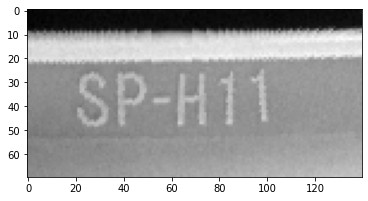

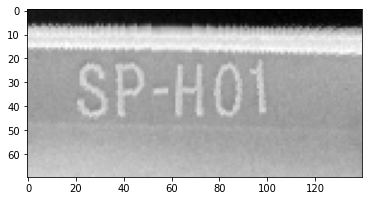

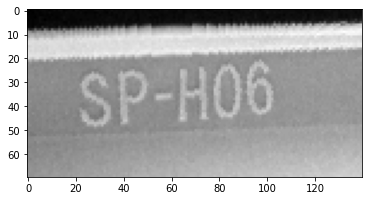

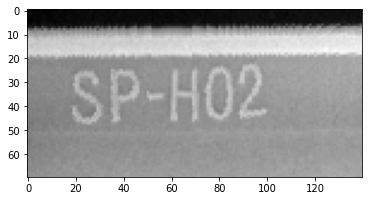

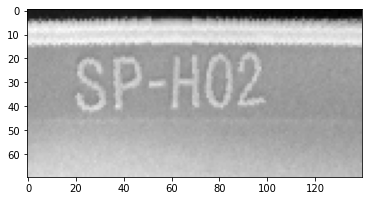

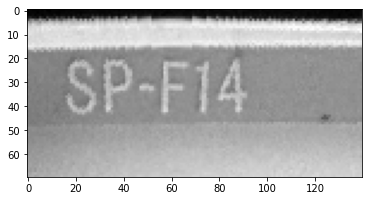

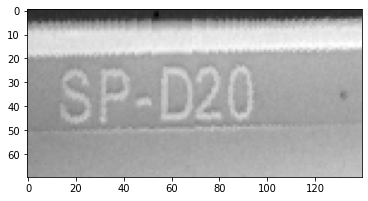

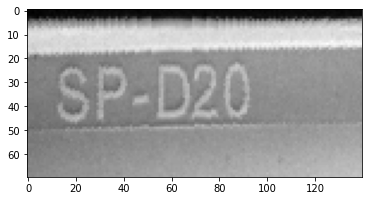

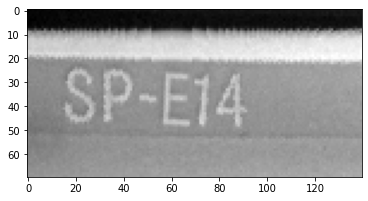

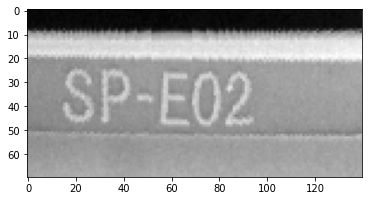

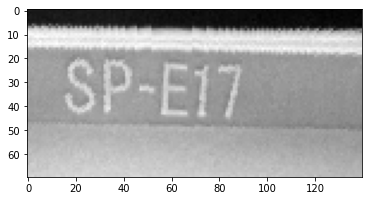

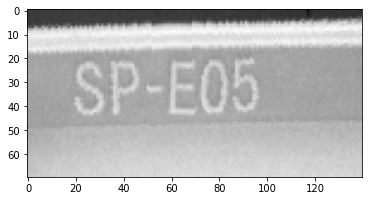

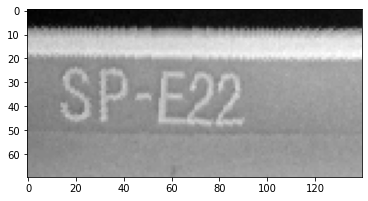

In [8]:
polar_transformed = [] # List to store polar-transformed images

for index, rot_img in enumerate(rotated_image):
    
    # Get the center and maximum radius of the cap
    center = cap_center[index][0]
    max_radius = cap_center[index][1]-30 # Adjusted maximum radius
    
    # Perform polar transformation on the rotated image
    polar_image = cv2.warpPolar(rot_img, (max_radius, 360*2), center, max_radius, flags=cv2.WARP_POLAR_LINEAR)
    
    # Rotate the polar-transformed image
    polar_transformed.append(cv2.rotate(polar_image, cv2.ROTATE_90_COUNTERCLOCKWISE))
#     plt.imshow(polar_transformed[index], cmap='gray')
#     plt.show()

rectified_cropped = [] # List to store rectified and cropped images

for index, pol_img in enumerate(polar_transformed):
    
    # Crop the ROI from the polar-transformed image
    rectified_cropped.append(pol_img[10:10+70, 2*240:2*(240+70)])
    
    plt.imshow(rectified_cropped[index], cmap='gray')
    plt.show()

This project has completed all task requirements. However, the positioning method of the tab center still lacks robustness. Detailed parameters can be adjusted according to subsequent needs.